In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kvair-seg/Kvasir-SEG/kavsir_bboxes.json
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju7d1tvt25bu08019dvw3uff.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju30qbm1ad3x0855znuhpz9u.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju5xq3tdm9fn0987pbedxdg5.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju7deifq2fzn0755lc8idyh8.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju2raxlosl630988jdbfy9b0.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju5uget8krjy0818kvywd0zu.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju8b1v3br45u087189kku66u.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju1hs0za7jha0855vj0mdrjt.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju171py4qiha0835u8sl59ds.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju3xeexgii1j0817zs68tb4g.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju88evxanv9r08176zkeovec.jpg
/kaggle/input/kvair-seg/Kvasir-SEG/images/cju8apjewqrk00801k5d71gky.jpg
/kaggle/in

In [2]:
import os
import shutil
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path_im = Path('/kaggle/input/kvair-seg/Kvasir-SEG/images')

path_lbl = Path('/kaggle/input/kvair-seg/Kvasir-SEG/masks')


In [4]:
fnames = get_image_files(path_im)   #images
label_names = get_image_files(path_lbl)    #masks

In [5]:
get_msk = lambda o: path_lbl/f'{o.stem}{o.suffix}' #o is the filename of the mask

In [6]:
img_fn = fnames[4]
img= PILImage.create(img_fn)

In [7]:
fnames[0]

Path('/kaggle/input/kvair-seg/Kvasir-SEG/images/cju7d1tvt25bu08019dvw3uff.jpg')

In [8]:
label_names[0]

Path('/kaggle/input/kvair-seg/Kvasir-SEG/masks/cju7d1tvt25bu08019dvw3uff.jpg')

<Axes: >

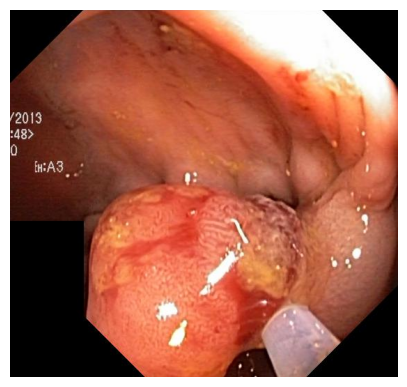

In [9]:
img_fn = fnames[4]
img= PILImage.create(img_fn)

img.show()

<Axes: >

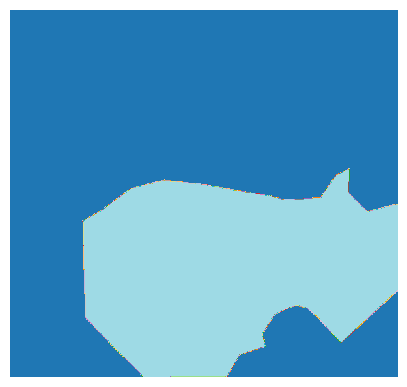

In [10]:
mask = PILMask.create(get_msk(img_fn))
mask.show(alpha=1)

In [11]:
print(tensor(mask))

tensor([[255,   1,   0,  ...,   0,   0,   0],
        [  1,   1,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]], dtype=torch.uint8)


In [12]:
codes = ['n','y']

In [13]:
sz= mask.shape; sz

(528, 557)

In [14]:
half = tuple(int(x/2) for x in sz); half

(264, 278)

In [15]:
#ORIGINAL

from PIL import Image


cancer = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=get_msk,
    item_tfms=[Resize(180),FlipItem(p=0.5),RandTransform(p=1)],
    # Resize images to 800x800
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats),
        IntToFloatTensor(div_mask=255)
    ]
)


In [16]:
source_p=Path('/kaggle/input/kvair-seg/Kvasir-SEG')

dls =  cancer.dataloaders(source_p,bs=2)


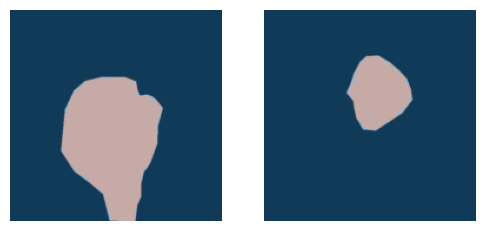

In [17]:
dls.show_batch()

In [18]:
name2id = {v:k for k,v in enumerate(codes)}

In [19]:
name2id

{'n': 0, 'y': 1}

In [20]:
opt=Adam

In [21]:

learn = unet_learner(dls, resnet34, metrics=[mean_dice])

NameError: name 'mean_dice' is not defined

In [ ]:
def binary_dice_coef(preds, targets, cls_idx):
    # Convert to binary format
    preds_bin = (preds == cls_idx).float()
    targets_bin = (targets == cls_idx).float()

    # Calculate intersection and union
    intersection = (preds_bin * targets_bin).sum()
    union = preds_bin.sum() + targets_bin.sum()

    # Dice coefficient
    dice = 2. * intersection / (union + 1e-8)  # Epsilon to avoid division by zero
    return dice


In [ ]:
def mean_dice(preds, targets):
    n_classes = preds.shape[1]  # Assuming preds are one-hot encoded or softmax
    preds_cls = preds.argmax(dim=1)  # Convert from probabilities to class indices
    mean_dice_score = 0.0

    for cls_idx in range(n_classes):
        mean_dice_score += binary_dice_coef(preds_cls, targets, cls_idx)

    return mean_dice_score / n_classes


In [ ]:
learn.summary()

In [ ]:
learn.freeze()
learn.fit_one_cycle(3,lr_max=1e-7)
learn.unfreeze()
learn.fit_one_cycle(20,lr_max=slice(1e-7,1e-3))

In [ ]:
learn.fine_tune(40, freeze_epochs=6)


In [ ]:
# ... [your existing code] ...

# Function to create a confusion matrix
def create_confusion_matrix(pred, truth, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    for i in range(num_classes):
        for j in range(num_classes):
            matrix[i, j] = np.logical_and(truth == i, pred == j).sum()
    return matrix

# Assuming 'n' is 0 and 'y' is 1
num_classes = 2
total_confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

# Get predictions and ground truths
preds, truths = learn.get_preds(dl=dls.valid)

# Process each prediction and corresponding truth
for pred, truth in zip(preds, truths):
    pred_mask = pred.argmax(dim=0).numpy() # Get the predicted class for each pixel
    truth_mask = truth.squeeze().numpy()   # Ground truth mask
    total_confusion_matrix += create_confusion_matrix(pred_mask, truth_mask, num_classes)

print("Confusion Matrix:")
print(total_confusion_matrix)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Reds', ax=ax)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)

# Call the function with your confusion matrix
class_names = ['False', 'True']
plot_confusion_matrix(total_confusion_matrix, class_names)
plt.show()


In [ ]:
learn.show_results()

In [ ]:
from fastai.vision.all import *

# Assuming you've trained a vision model and saved it in 'learn' variable
# Replace 'your_model_name.pkl' with your preferred file name
learn.export('your_model_name.pkl')
